In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger



from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs
from project.sheaf_learner import coboundary_learner_on_graph_signal
from project.sheaf_diffusion import sheaf_diffusion
from project.sheaf_simultaneous_sparse import sheaf_gradient_flow
from project.sheaf_simultaneous_potential import sheaf_gradient_flow_potential

In [5]:
import wandb

In [6]:
wandb.login()

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


True

In [7]:
dataset = get_dataset('texas')
data = dataset[0]
data = get_fixed_splits(data, 'texas', 0)

In [8]:
graph = to_networkx(data)

In [9]:
mask = {'train_mask':data.train_mask, 
        'val_mask':data.val_mask, 
        'test_mask':data.test_mask
       }

In [10]:
sweep_config = {
    'method': 'random'
    }

In [11]:
metric = {
    'name': 'val_acc',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric

In [12]:
parameters_dict = {
    'dv': {
        'distribution': 'categorical',
        'values': [2,3,4,5]
    },
    'de': {
        'distribution': 'categorical',
        'values': [2,3,4,5]
    },
    'input_dropout': {
        'distribution': 'uniform',
        'min': 0.1,
        'max': 0.9
    },
    'dropout': {
        'distribution': 'uniform',
        'min': 0.1, 
        'max': 0.9
    },
    #'graph':{
    #    'value': graph,       
    #},
    
    #'mask':{
    #    'value': mask
    #},
    #'Nv':{
    #    'value': 183
    #},
    #'Ne':{
    #    'value': 558
    #},
    'layers':{
        'distribution': 'categorical',
        'values': [2,3,4,5,6,7]
    },
    'channels':{
        'distribution': 'categorical',
        'values': [2,3,4,5]
    },
    'batch_size':{
        'distribution': 'categorical',
        'values': [60]
    },
    #'input_dim':{ 'value': 1703},
    #'output_dim':{'value':5},
    #'left_weights':{'value':True},
    #'right_weights':{'value':True},
    #'potential':{'value':'radial'},
    #'use_act':{'value':True},
    #'augmented':{'value':True},
    #'add_lp':{'value':True},
    #'add_hp':{'value':True},
    'learning_rate':{
        'distribution':'categorical',
        'values':[0.01]
    }
    
    
    
}

sweep_config['parameters'] = parameters_dict

In [13]:
import pprint

In [14]:
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'batch_size': {'distribution': 'categorical', 'values': [60]},
                'channels': {'distribution': 'categorical',
                             'values': [2, 3, 4, 5]},
                'de': {'distribution': 'categorical', 'values': [2, 3, 4, 5]},
                'dropout': {'distribution': 'uniform', 'max': 0.9, 'min': 0.1},
                'dv': {'distribution': 'categorical', 'values': [2, 3, 4, 5]},
                'input_dropout': {'distribution': 'uniform',
                                  'max': 0.9,
                                  'min': 0.1},
                'layers': {'distribution': 'categorical',
                           'values': [2, 3, 4, 5, 6, 7]},
                'learning_rate': {'distribution': 'categorical',
                                  'values': [0.01]}}}


In [15]:
sweep_id = wandb.sweep(sweep_config, project="Sweep_sheaf_coboundary_potential_1")

Create sweep with ID: yi77rkye
Sweep URL: https://wandb.ai/saepark/Sweep_sheaf_coboundary_potential_1/sweeps/yi77rkye


In [16]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-sheafsweep-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [17]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger_diffusion = WandbLogger(project="Sweep_sheaf_learning_diffusion_with_coboundary_potential")

    # setup data
    sheaf_dm = SheafDataModule_ForGraphs(data, wandb.config.batch_size , 1)

    # setup model - note how we refer to sweep parameters with wandb.config
    model_diffusion = sheaf_gradient_flow_potential(graph, 183, wandb.config.dv, graph.number_of_edges(), wandb.config.de, wandb.config.layers, 1703,5, wandb.config.channels, True, True, 'radial', mask, True,True,True,True, wandb.config.dropout,wandb.config.input_dropout, wandb.config.learning_rate)

    # setup Trainer
    #trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)
    trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion)

    # train
    trainer.fit(model_diffusion, sheaf_dm)

In [ ]:
wandb.agent(sweep_id, function=sweep_iteration)

wandb: Agent Starting Run: gjhtm0i2 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.13632740135562138
wandb: 	dv: 5
wandb: 	input_dropout: 0.4522070003861812
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Starting to init trainer!


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/m

Trainer is init now


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
--------------------------------------------------------------
0  | coboundary_vec_out         | ParameterList | 5.6 K 
1  | coboundary_vec_in          | ParameterList | 5.6 K 
2  | graph_to_sheaf             | Linear        | 47.7 K
3  | graph_to_sheaf2            | Linear        | 812   
4  | self_energy_channel_mixing | Linear        | 20    
5  | self_energy_stalk_mixing   | Linear        | 56    
6  | diffusion_stalk_mixing     | Linear        | 56    
7  | diffusion_channel_mixing   | Linear        | 20    
8  | lin_left_weights           | ModuleList    | 294   
9  | lin_right_weights          | ModuleList    | 96    
10 | batch_norms                | ModuleList    | 0     
11 | epsilons                   | ParameterList | 42    
12 | lin2                       | Linear        | 145   
--------------------------------------------------------------
61.0 K    Trainable params
0     

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇██
train_acc,▁▅▆▄███▇▇▇██▇█
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_acc,█▆▄▃▂▃▃▂▁▂▂▁
val_loss,▃▁▂▄▆▆▆▄▅▆▇█
epoch,11
train_acc,1.0
train_loss,0.01473
trainer/global_step,719
val_acc,0.37288


wandb: Agent Starting Run: jqwdgzta with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.28651260009005713
wandb: 	dv: 2
wandb: 	input_dropout: 0.19146830988602404
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇██
train_acc,▁▅▆▆▇▇▇▇█████
train_loss,█▅▃▃▂▂▃▂▂▁▁▂▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
val_acc,█▃▂▁▂▁▄▂▂▁▁
val_loss,▁▁▂▃▃▃▂▅▇▇█
epoch,10
train_acc,0.97701
train_loss,0.07503
trainer/global_step,659
val_acc,0.32203


wandb: Agent Starting Run: fawbigg4 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.8861558578206972
wandb: 	dv: 4
wandb: 	input_dropout: 0.1182429855470919
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,1.17637
trainer/global_step,59
val_acc,0.52542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gl6lzr8f with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.5151324050623128
wandb: 	dv: 2
wandb: 	input_dropout: 0.7661062457016516
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.12644
train_loss,2.0541
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: oceyt4xb with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.25908306080272503
wandb: 	dv: 3
wandb: 	input_dropout: 0.724633639296758
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.43047
trainer/global_step,59
val_acc,0.71186


wandb: Agent Starting Run: u5fuojey with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.7337135318449385
wandb: 	dv: 5
wandb: 	input_dropout: 0.15192122891731624
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇██
train_acc,▁████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
val_acc,▁▅██▇▅▄▄▅▄▄
val_loss,▁▄▄▆▆▇▇▇▆█▆
epoch,10
train_acc,1.0
train_loss,0.00056
trainer/global_step,659
val_acc,0.62712


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e5ahnwhs with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.6846864703613001
wandb: 	dv: 4
wandb: 	input_dropout: 0.256887624372915
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,28.20491
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: xrst7ych with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.6741307982287201
wandb: 	dv: 5
wandb: 	input_dropout: 0.3867847932816151
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,98.2477
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: nxe4htb2 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.7739616371432232
wandb: 	dv: 5
wandb: 	input_dropout: 0.8889789421305231
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.32184
train_loss,182.79555
trainer/global_step,59
val_acc,0.49153


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z3kfaawd with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.5283717253710196
wandb: 	dv: 5
wandb: 	input_dropout: 0.7602156907798941
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.44828
train_loss,6.70356
trainer/global_step,59
val_acc,0.22034


wandb: Agent Starting Run: 6zhxedo1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.2466280033240256
wandb: 	dv: 5
wandb: 	input_dropout: 0.4483767581952043
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.25287
train_loss,59.25102
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: ltff9bqi with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.8678523550825731
wandb: 	dv: 5
wandb: 	input_dropout: 0.6392480554225877
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.41379
train_loss,15.703
trainer/global_step,59
val_acc,0.15254


wandb: Agent Starting Run: koi624zu with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.1160365102227325
wandb: 	dv: 3
wandb: 	input_dropout: 0.5747484752903497
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.35632
train_loss,58.60254
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: kag9ld66 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.2857506129838999
wandb: 	dv: 2
wandb: 	input_dropout: 0.6090384794952828
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,4.62051
trainer/global_step,59
val_acc,0.38983


wandb: Agent Starting Run: tzzzwd5a with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.23267164996277476
wandb: 	dv: 4
wandb: 	input_dropout: 0.7480073278642658
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇██
train_acc,▁▇███████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
val_acc,█▆▆▄▃▅▄▄▁▅▅
val_loss,▁▂▂▅▅▄█▆█▅▆
epoch,10
train_acc,1.0
train_loss,0.00204
trainer/global_step,659
val_acc,0.64407


wandb: Agent Starting Run: p3ih38ul with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.514761274645279
wandb: 	dv: 2
wandb: 	input_dropout: 0.3365462883161399
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,0.95051
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: jayh3264 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.5496363905770553
wandb: 	dv: 2
wandb: 	input_dropout: 0.35025325005077
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,69.91568
trainer/global_step,59
val_acc,0.18644


wandb: Agent Starting Run: s26thjtk with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.7481366556330612
wandb: 	dv: 3
wandb: 	input_dropout: 0.32357579637533895
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,1.49273
trainer/global_step,59
val_acc,0.23729


wandb: Agent Starting Run: 0tgo9yg9 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.89467099040402
wandb: 	dv: 4
wandb: 	input_dropout: 0.6215555454272645
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_acc,▁▆██████████████████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_acc,▂▁▃▄▄▆█▄▇▆▆▃▆▄▅▃▆
val_loss,▃▄▄▅▃▄▁▄▃▃▅▇▄▅▆█▅
epoch,16
train_acc,1.0
train_loss,0.00038
trainer/global_step,1019
val_acc,0.74576


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oiqqspom with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.11312061847280389
wandb: 	dv: 5
wandb: 	input_dropout: 0.3048874150538854
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,2.33746
trainer/global_step,59
val_acc,0.61017


wandb: Agent Starting Run: g7r6o1au with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.7264317005746322
wandb: 	dv: 5
wandb: 	input_dropout: 0.4846104494591851
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.56322
train_loss,1.09751
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: ex13v2pj with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.4826373837125967
wandb: 	dv: 4
wandb: 	input_dropout: 0.5046564120911045
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.27586
train_loss,185.2227
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: j4l5iye6 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.14044774146665084
wandb: 	dv: 2
wandb: 	input_dropout: 0.4289565698008917
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.22989
train_loss,2.4073
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: lsuky2fu with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.892411975739582
wandb: 	dv: 5
wandb: 	input_dropout: 0.5722483367558091
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.50575
train_loss,1.72449
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: 70az7gik with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.3986739005657247
wandb: 	dv: 4
wandb: 	input_dropout: 0.858683363412616
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,4.67962
trainer/global_step,59
val_acc,0.20339


wandb: Agent Starting Run: f20si3xa with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.6805156879842754
wandb: 	dv: 4
wandb: 	input_dropout: 0.11878412687303604
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.28736
train_loss,2.64251
trainer/global_step,59
val_acc,0.25424


wandb: Agent Starting Run: g33y6ltq with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.4873584919245888
wandb: 	dv: 5
wandb: 	input_dropout: 0.8016805031327529
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.34483
train_loss,1.42234
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: fbie9nqy with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.5473916941960808
wandb: 	dv: 5
wandb: 	input_dropout: 0.7536533731364858
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,7.96389
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: 3qp27b59 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.6754219926357963
wandb: 	dv: 4
wandb: 	input_dropout: 0.4510602947486766
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.57471
train_loss,0.90867
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: h1mknnlw with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.5164400230955397
wandb: 	dv: 5
wandb: 	input_dropout: 0.1772634863465462
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,0.80738
trainer/global_step,59
val_acc,0.32203


wandb: Agent Starting Run: r9usuktj with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.2752829482746396
wandb: 	dv: 4
wandb: 	input_dropout: 0.6497464105778704
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.68966
train_loss,0.8206
trainer/global_step,59
val_acc,0.32203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q01mqycx with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.572025248414832
wandb: 	dv: 5
wandb: 	input_dropout: 0.12941678762423986
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.89655
train_loss,0.27034
trainer/global_step,59
val_acc,0.76271


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ajk6reh with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.5440471423661039
wandb: 	dv: 4
wandb: 	input_dropout: 0.594978713316897
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,116.32767
trainer/global_step,59
val_acc,0.27119


wandb: Agent Starting Run: si2xama5 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.8035466819133961
wandb: 	dv: 4
wandb: 	input_dropout: 0.31374134324179404
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.17065
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: mqh7wjc3 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.25165052462370585
wandb: 	dv: 3
wandb: 	input_dropout: 0.5892737997758303
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.41379
train_loss,10.85526
trainer/global_step,59
val_acc,0.64407


wandb: Agent Starting Run: umfed40j with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.30901549142899043
wandb: 	dv: 2
wandb: 	input_dropout: 0.42812775307559103
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,0.92621
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: 1c1yyh8g with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.1005456049435118
wandb: 	dv: 5
wandb: 	input_dropout: 0.14255988784132756
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.7931
train_loss,0.62388
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: vyse7poe with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.29201887750582234
wandb: 	dv: 3
wandb: 	input_dropout: 0.4933893949377018
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,73.40923
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 9hdblg6z with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.26702216615606045
wandb: 	dv: 4
wandb: 	input_dropout: 0.1572313198679016
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,2.29676
trainer/global_step,59
val_acc,0.23729


wandb: Agent Starting Run: 2derjwge with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.8955085037994365
wandb: 	dv: 2
wandb: 	input_dropout: 0.6478382655774927
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.27586
train_loss,20.12996
trainer/global_step,59
val_acc,0.37288


wandb: Agent Starting Run: dalrj1bk with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.5658936073362397
wandb: 	dv: 3
wandb: 	input_dropout: 0.7377441999401011
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,0.9802
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: bkzgy1j5 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.25000013074827376
wandb: 	dv: 2
wandb: 	input_dropout: 0.15988615080266913
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,1.43217
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: i8072e7a with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.27288028730039465
wandb: 	dv: 3
wandb: 	input_dropout: 0.6312417724932234
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.34483
train_loss,19.005
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: 0jqh1b4z with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.3672529237786055
wandb: 	dv: 4
wandb: 	input_dropout: 0.8584938577414375
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,1.36667
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: x78ppvq2 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.22673234859234415
wandb: 	dv: 2
wandb: 	input_dropout: 0.8815251855673714
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.43678
train_loss,6.85075
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: q13pvepz with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.20117150112501225
wandb: 	dv: 3
wandb: 	input_dropout: 0.6474141749756251
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,1.10828
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: 21s56jc4 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.734269034747017
wandb: 	dv: 5
wandb: 	input_dropout: 0.6168048415634187
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.42529
train_loss,42.82785
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: w7v48nhi with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.21717359407623987
wandb: 	dv: 4
wandb: 	input_dropout: 0.33806904431314855
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.75862
train_loss,0.68715
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: p8c4uvlq with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.11842617778619403
wandb: 	dv: 4
wandb: 	input_dropout: 0.27631690245587537
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,6.1347
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: s4o6bhk1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.3431350559741787
wandb: 	dv: 2
wandb: 	input_dropout: 0.7722369289292689
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.50575
train_loss,1.02066
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 6gkh6dcr with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.8508611803114766
wandb: 	dv: 2
wandb: 	input_dropout: 0.7230973787780103
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.56322
train_loss,1.13968
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: nbyknby1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.7395279897683896
wandb: 	dv: 3
wandb: 	input_dropout: 0.15209356176301014
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.17904
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: o9iorshw with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.29187034303250925
wandb: 	dv: 3
wandb: 	input_dropout: 0.3254427804216764
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,10.67785
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: z0g5gksc with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.7258230013778384
wandb: 	dv: 5
wandb: 	input_dropout: 0.5123392929458204
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.15372
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: maf7lusm with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.7441637886461127
wandb: 	dv: 3
wandb: 	input_dropout: 0.5990172438655158
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.41379
train_loss,2.00794
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: w1n7gxuj with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.5763777171951563
wandb: 	dv: 5
wandb: 	input_dropout: 0.8906961912140232
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,1.01083
trainer/global_step,59
val_acc,0.37288


wandb: Agent Starting Run: 07ibawcq with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.487722976766395
wandb: 	dv: 4
wandb: 	input_dropout: 0.6535992334260927
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.63218
train_loss,0.93647
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: i7xfu5na with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.1109188695346802
wandb: 	dv: 4
wandb: 	input_dropout: 0.303880718513755
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.81609
train_loss,0.48222
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: o4gm1wdr with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.5309865768832276
wandb: 	dv: 3
wandb: 	input_dropout: 0.6283710441950967
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,48.05618
trainer/global_step,59
val_acc,0.15254


wandb: Agent Starting Run: 6icaemu1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.5142860802074826
wandb: 	dv: 5
wandb: 	input_dropout: 0.7779655285692478
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,7.97029
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: wyine2p1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.19829495714412976
wandb: 	dv: 5
wandb: 	input_dropout: 0.1152509494600774
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.50575
train_loss,6.60486
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: ffnw85wp with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.6616509452532406
wandb: 	dv: 5
wandb: 	input_dropout: 0.7875067868972639
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,1.16598
trainer/global_step,59
val_acc,0.38983


wandb: Agent Starting Run: u2w6ywhh with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.7696089646773968
wandb: 	dv: 5
wandb: 	input_dropout: 0.4478228988473356
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.64368
train_loss,0.85089
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: yznk5m7o with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.17293741036515353
wandb: 	dv: 2
wandb: 	input_dropout: 0.721242535511736
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,16.26056
trainer/global_step,59
val_acc,0.22034


wandb: Agent Starting Run: vgpbbgvu with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.19265166046242277
wandb: 	dv: 5
wandb: 	input_dropout: 0.7368928284481203
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.89655
train_loss,0.32669
trainer/global_step,59
val_acc,0.61017


wandb: Agent Starting Run: 2gbsbacb with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.2706671738229465
wandb: 	dv: 2
wandb: 	input_dropout: 0.7045857881700925
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,1.47979
trainer/global_step,59
val_acc,0.67797


wandb: Agent Starting Run: ggdzb8px with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.31195159931260574
wandb: 	dv: 2
wandb: 	input_dropout: 0.631464355865214
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.62069
train_loss,0.93592
trainer/global_step,59
val_acc,0.49153


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fwocb4qw with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.4815274064330619
wandb: 	dv: 4
wandb: 	input_dropout: 0.4404477531954444
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,0.92528
trainer/global_step,59
val_acc,0.35593


wandb: Agent Starting Run: knxe9wku with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.14244987335194192
wandb: 	dv: 2
wandb: 	input_dropout: 0.10146282415592066
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,1.05271
trainer/global_step,59
val_acc,0.59322


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: k2nnix83 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.2272223196182855
wandb: 	dv: 2
wandb: 	input_dropout: 0.5021996316822651
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,9.79958
trainer/global_step,59
val_acc,0.32203


wandb: Agent Starting Run: 5i4hlrq1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.22848143301554355
wandb: 	dv: 4
wandb: 	input_dropout: 0.4336327857898451
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.94253
train_loss,0.1385
trainer/global_step,59
val_acc,0.74576


wandb: Agent Starting Run: s5f7zqmr with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.511877073327456
wandb: 	dv: 2
wandb: 	input_dropout: 0.8651748731721404
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.73563
train_loss,0.80769
trainer/global_step,59
val_acc,0.59322


wandb: Agent Starting Run: 2r0a0g8q with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.8657055849595473
wandb: 	dv: 3
wandb: 	input_dropout: 0.3072734578134756
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.73563
train_loss,0.71942
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: ics0kr35 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.4321517261803186
wandb: 	dv: 4
wandb: 	input_dropout: 0.1442559232092564
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.98851
train_loss,0.06054
trainer/global_step,59
val_acc,0.64407


wandb: Agent Starting Run: mthyqjbi with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.35057531498021344
wandb: 	dv: 5
wandb: 	input_dropout: 0.29586374824848943
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.95402
train_loss,0.12983
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: o1h8vxlb with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.4296396643171349
wandb: 	dv: 3
wandb: 	input_dropout: 0.7828064793123599
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.94222
trainer/global_step,59
val_acc,0.45763


wandb: Agent Starting Run: z6snyoqe with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.2245467014966445
wandb: 	dv: 5
wandb: 	input_dropout: 0.6103433483314512
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.50575
train_loss,2.09913
trainer/global_step,59
val_acc,0.27119


wandb: Agent Starting Run: j6yk1nmt with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.3223410982060389
wandb: 	dv: 3
wandb: 	input_dropout: 0.5615336527424474
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.85057
train_loss,0.4473
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: lvmdq58q with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.8070400758373205
wandb: 	dv: 2
wandb: 	input_dropout: 0.688081232991695
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,1.07415
trainer/global_step,59
val_acc,0.67797


wandb: Agent Starting Run: 1587mubj with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.6854660312306124
wandb: 	dv: 5
wandb: 	input_dropout: 0.6658165370203695
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.68966
train_loss,0.73843
trainer/global_step,59
val_acc,0.35593


wandb: Agent Starting Run: xhyzirpi with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.41388689904886033
wandb: 	dv: 4
wandb: 	input_dropout: 0.644383694797812
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,19.3999
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: 1vjhrlfn with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.12496784069463232
wandb: 	dv: 3
wandb: 	input_dropout: 0.5599254277215999
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,37.73148
trainer/global_step,59
val_acc,0.52542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 451g8zfu with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.662789471841319
wandb: 	dv: 5
wandb: 	input_dropout: 0.8541747218309889
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.12088
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: gagvs4s8 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.7346023851145442
wandb: 	dv: 3
wandb: 	input_dropout: 0.14390280185543292
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.33333
train_loss,3.68823
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: tge6yvmh with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.5699000266167711
wandb: 	dv: 3
wandb: 	input_dropout: 0.5787598099865693
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,1.12404
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: ms6ovdqx with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.1335540403659306
wandb: 	dv: 4
wandb: 	input_dropout: 0.4396360433024942
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.98851
train_loss,0.0255
trainer/global_step,59
val_acc,0.74576


wandb: Agent Starting Run: 51ffqbfl with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.6633524930092624
wandb: 	dv: 4
wandb: 	input_dropout: 0.11420280133278782
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,19.65963
trainer/global_step,59
val_acc,0.11864


wandb: Agent Starting Run: 287luwbv with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.5397259595002434
wandb: 	dv: 5
wandb: 	input_dropout: 0.2406921172114883
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.90805
train_loss,0.30638
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: ibq6fbi5 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.13083254144944548
wandb: 	dv: 2
wandb: 	input_dropout: 0.6858502041958575
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.64368
train_loss,0.93691
trainer/global_step,59
val_acc,0.54237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xn20x98s with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.5951086146917808
wandb: 	dv: 4
wandb: 	input_dropout: 0.7362828855272099
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,1.44018
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: 0nj5mvlq with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.3944094237591821
wandb: 	dv: 2
wandb: 	input_dropout: 0.5178994806237113
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,2.25147
trainer/global_step,59
val_acc,0.64407


wandb: Agent Starting Run: ujzl2rtt with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.2738408106848158
wandb: 	dv: 5
wandb: 	input_dropout: 0.1917991409505928
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,4.78917
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: g9l3esd4 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.8763625435322518
wandb: 	dv: 4
wandb: 	input_dropout: 0.48538958789264697
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.16616
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 330icgl0 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.3913867009651846
wandb: 	dv: 2
wandb: 	input_dropout: 0.5195946955264523
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,1.04666
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: v5q8gtuk with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.2156659862215934
wandb: 	dv: 2
wandb: 	input_dropout: 0.3717324160260472
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.22989
train_loss,95.38324
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 6pibsodn with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.40131554031231687
wandb: 	dv: 2
wandb: 	input_dropout: 0.6636914650733241
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.63218
train_loss,0.87423
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: thaig09i with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.6647803388151373
wandb: 	dv: 2
wandb: 	input_dropout: 0.7201079781386239
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,2.65293
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 4fwpium1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.8117262542420635
wandb: 	dv: 2
wandb: 	input_dropout: 0.5645141179196699
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.29885
train_loss,8.28238
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: acuea9b2 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.1398017790072155
wandb: 	dv: 3
wandb: 	input_dropout: 0.5907828341898212
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,1.24841
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: wfvy13qw with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.29563991949958024
wandb: 	dv: 3
wandb: 	input_dropout: 0.4400779438158742
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,2.8022
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: 8rrug76k with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.8440259747660749
wandb: 	dv: 2
wandb: 	input_dropout: 0.23405062296631104
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.22989
train_loss,12.89427
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 0s3okini with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.8090017031230812
wandb: 	dv: 4
wandb: 	input_dropout: 0.11729700610483064
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.29885
train_loss,2.72167
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: tf8n8wv6 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.4722226874441828
wandb: 	dv: 4
wandb: 	input_dropout: 0.8603171304380213
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.3908
train_loss,1.24984
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: or6dobus with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.4279215946320501
wandb: 	dv: 2
wandb: 	input_dropout: 0.1770666887188365
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.44828
train_loss,1.34071
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: zutgwl0y with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.5746437462944838
wandb: 	dv: 3
wandb: 	input_dropout: 0.8398026761127748
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,252.7865
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: uk01r7dg with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.39999601052702305
wandb: 	dv: 4
wandb: 	input_dropout: 0.4606380871773119
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.32184
train_loss,2.5329
trainer/global_step,59
val_acc,0.67797


wandb: Agent Starting Run: a0yaw1yh with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.2574393844271403
wandb: 	dv: 3
wandb: 	input_dropout: 0.16805854373960205
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.58621
train_loss,1.00997
trainer/global_step,59
val_acc,0.15254


wandb: Agent Starting Run: 3dv7j4me with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.7536566034913535
wandb: 	dv: 5
wandb: 	input_dropout: 0.8104194578379256
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,7.16486
trainer/global_step,59
val_acc,0.16949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u9aw0lu1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.16855035069642188
wandb: 	dv: 2
wandb: 	input_dropout: 0.47834333229521775
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.82759
train_loss,0.52334
trainer/global_step,59
val_acc,0.54237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: borud0kn with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.2753827424852672
wandb: 	dv: 5
wandb: 	input_dropout: 0.7858174279653056
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.96552
train_loss,0.14974
trainer/global_step,59
val_acc,0.77966


wandb: Agent Starting Run: roce1ck3 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.7665925372668305
wandb: 	dv: 5
wandb: 	input_dropout: 0.1252439623794558
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.36782
train_loss,4.52945
trainer/global_step,59
val_acc,0.23729


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4oiwnj8w with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.11955560106011703
wandb: 	dv: 3
wandb: 	input_dropout: 0.8304569760165964
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.91954
train_loss,0.2133
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: 7hwdgn2g with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.22290253790159417
wandb: 	dv: 2
wandb: 	input_dropout: 0.15351838939415582
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.10345
train_loss,25.01908
trainer/global_step,59
val_acc,0.44068


wandb: Agent Starting Run: lyn7247d with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.5379286556883653
wandb: 	dv: 5
wandb: 	input_dropout: 0.759669722766486
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,1.57682
trainer/global_step,59
val_acc,0.13559


wandb: Agent Starting Run: 08ie48op with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.3199715377169386
wandb: 	dv: 4
wandb: 	input_dropout: 0.8064571751262783
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,6.47027
trainer/global_step,59
val_acc,0.23729


wandb: Agent Starting Run: 7xi1hzu5 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.3154118595042871
wandb: 	dv: 2
wandb: 	input_dropout: 0.5493215846275837
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,15.76945
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 223d8crh with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.7886145602773995
wandb: 	dv: 4
wandb: 	input_dropout: 0.39285422225646194
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.34483
train_loss,120.69978
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: ywu58cps with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.18179911508661864
wandb: 	dv: 4
wandb: 	input_dropout: 0.26398156089594516
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,24.81383
trainer/global_step,59
val_acc,0.30508


wandb: Agent Starting Run: ndxyjcdd with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.6412766550424671
wandb: 	dv: 3
wandb: 	input_dropout: 0.8708191838071718
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.29885
train_loss,117.98885
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: n1lnl9xw with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.6497248674878399
wandb: 	dv: 4
wandb: 	input_dropout: 0.37109094409377874
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.28736
train_loss,194.77054
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: zlxemk5w with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.4003449595145695
wandb: 	dv: 3
wandb: 	input_dropout: 0.6226926117833311
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.3908
train_loss,27.71247
trainer/global_step,59
val_acc,0.52542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3fxbc39x with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.79305127386709
wandb: 	dv: 4
wandb: 	input_dropout: 0.10395168844970304
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.28736
train_loss,2.02652
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 2e2bj0hm with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.3658042558506297
wandb: 	dv: 3
wandb: 	input_dropout: 0.49392514973131063
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.42529
train_loss,28.51381
trainer/global_step,59
val_acc,0.37288


wandb: Agent Starting Run: qslzbtob with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.124776352463498
wandb: 	dv: 4
wandb: 	input_dropout: 0.2536222766472716
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.86207
train_loss,0.38601
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: 0g5cbymq with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.6495305512341986
wandb: 	dv: 3
wandb: 	input_dropout: 0.7070669503392846
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.43678
train_loss,23.92442
trainer/global_step,59
val_acc,0.13559


wandb: Agent Starting Run: 27e1o994 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.44973573189357374
wandb: 	dv: 3
wandb: 	input_dropout: 0.36744253472728794
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.32184
train_loss,258.6376
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 1x0mchmp with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.6991693157839991
wandb: 	dv: 2
wandb: 	input_dropout: 0.7946337500971877
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,6.30125
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: f23tol8d with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.6853151280716294
wandb: 	dv: 4
wandb: 	input_dropout: 0.8644038011394389
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,2.03996
trainer/global_step,59
val_acc,0.32203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6y70vrv5 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.2918698482466524
wandb: 	dv: 5
wandb: 	input_dropout: 0.5644941477982899
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.77011
train_loss,0.65923
trainer/global_step,59
val_acc,0.59322


wandb: Agent Starting Run: sw2751o9 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.38166248926224267
wandb: 	dv: 5
wandb: 	input_dropout: 0.6384583796684955
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.96552
train_loss,0.07271
trainer/global_step,59
val_acc,0.74576


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vr45pri8 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.5781124779406577
wandb: 	dv: 2
wandb: 	input_dropout: 0.2800426403661496
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,1.11409
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 62ffucr6 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.6518131691942559
wandb: 	dv: 3
wandb: 	input_dropout: 0.3380811934418697
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,1.34027
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: mbyp7mjk with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.4121833159945526
wandb: 	dv: 4
wandb: 	input_dropout: 0.11604317069637728
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.24138
train_loss,11.81707
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: rn64w2rq with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.5741094394153057
wandb: 	dv: 5
wandb: 	input_dropout: 0.7843523796893341
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.50575
train_loss,1.21649
trainer/global_step,59
val_acc,0.28814


wandb: Agent Starting Run: j8jfcvwj with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.3625669110013843
wandb: 	dv: 4
wandb: 	input_dropout: 0.2550073601699424
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.41379
train_loss,40.56369
trainer/global_step,59
val_acc,0.11864


wandb: Agent Starting Run: 5tc28is4 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.27258229557607494
wandb: 	dv: 3
wandb: 	input_dropout: 0.3983914722600924
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,5.48993
trainer/global_step,59
val_acc,0.45763


wandb: Agent Starting Run: m4s65vno with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.3317089848465302
wandb: 	dv: 4
wandb: 	input_dropout: 0.21644905020317415
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.21839
train_loss,18.8353
trainer/global_step,59
val_acc,0.59322


wandb: Agent Starting Run: l6d4i1sv with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.3011228776684363
wandb: 	dv: 3
wandb: 	input_dropout: 0.3319760214172871
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.50575
train_loss,1.65222
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: mzlkjs8v with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.4259698254621769
wandb: 	dv: 5
wandb: 	input_dropout: 0.3347967873253249
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.89655
train_loss,0.34978
trainer/global_step,59
val_acc,0.57627


wandb: Agent Starting Run: k86pz7cd with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.24542194833541145
wandb: 	dv: 5
wandb: 	input_dropout: 0.6956729988124587
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.21839
train_loss,92.49813
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: jl2hc3gt with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.8773606069605465
wandb: 	dv: 4
wandb: 	input_dropout: 0.28837623144671626
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.56322
train_loss,1.38157
trainer/global_step,59
val_acc,0.28814


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z71f6h0v with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.2034344296227499
wandb: 	dv: 4
wandb: 	input_dropout: 0.5169692325064933
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.62069
train_loss,0.96081
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 70l2lcuj with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.6216478179329455
wandb: 	dv: 2
wandb: 	input_dropout: 0.4945875135917902
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,2.08697
trainer/global_step,59
val_acc,0.33898


wandb: Agent Starting Run: 49iqcghw with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.20784704279157387
wandb: 	dv: 4
wandb: 	input_dropout: 0.8018513417060279
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.57471
train_loss,1.52298
trainer/global_step,59
val_acc,0.25424


wandb: Agent Starting Run: 8lyjr265 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.11055290751849736
wandb: 	dv: 2
wandb: 	input_dropout: 0.45231562105109224
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.58621
train_loss,1.13887
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: y4zjevci with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.15229808805625542
wandb: 	dv: 2
wandb: 	input_dropout: 0.17838331513054656
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.96552
train_loss,0.18831
trainer/global_step,59
val_acc,0.71186


wandb: Agent Starting Run: y3hh046w with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.6478938630458516
wandb: 	dv: 4
wandb: 	input_dropout: 0.8065438311345267
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.85057
train_loss,0.66381
trainer/global_step,59
val_acc,0.42373


wandb: Agent Starting Run: yjsby951 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.6037022941411008
wandb: 	dv: 2
wandb: 	input_dropout: 0.17005803963746963
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,4.16949
trainer/global_step,59
val_acc,0.64407


wandb: Agent Starting Run: l8wl88x3 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.4434054215379032
wandb: 	dv: 5
wandb: 	input_dropout: 0.5781220391740995
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,69.35346
trainer/global_step,59
val_acc,0.18644


wandb: Agent Starting Run: 2qi2diah with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.33533539651998484
wandb: 	dv: 5
wandb: 	input_dropout: 0.5863444928031148
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,1.0
train_loss,0.01616
trainer/global_step,59
val_acc,0.67797


wandb: Agent Starting Run: 6x2myj8p with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.24416252229837437
wandb: 	dv: 3
wandb: 	input_dropout: 0.356649326424997
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,4.47287
trainer/global_step,59
val_acc,0.59322


wandb: Agent Starting Run: zwklckd7 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.28508342132741105
wandb: 	dv: 3
wandb: 	input_dropout: 0.4367747620603398
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.43678
train_loss,7.89269
trainer/global_step,59
val_acc,0.61017


wandb: Agent Starting Run: cu23t7lh with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.5316252978789102
wandb: 	dv: 5
wandb: 	input_dropout: 0.2500565529487518
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,70.50116
trainer/global_step,59
val_acc,0.59322


wandb: Agent Starting Run: ji05xdn2 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.7411531024368407
wandb: 	dv: 4
wandb: 	input_dropout: 0.4707087923823482
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.44828
train_loss,54.4924
trainer/global_step,59
val_acc,0.0678


wandb: Agent Starting Run: 6f4sbcex with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.8333034422730986
wandb: 	dv: 3
wandb: 	input_dropout: 0.726198185107064
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.56322
train_loss,5.30374
trainer/global_step,59
val_acc,0.50847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x4voec26 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.2949301597599403
wandb: 	dv: 2
wandb: 	input_dropout: 0.5403507711918826
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.91954
train_loss,0.31923
trainer/global_step,59
val_acc,0.69492


wandb: Agent Starting Run: wf456l19 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.5946494164261176
wandb: 	dv: 2
wandb: 	input_dropout: 0.8108828976140946
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,4.44426
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: 7abgmla3 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.12238589720853704
wandb: 	dv: 3
wandb: 	input_dropout: 0.3948831286701307
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.62069
train_loss,1.43932
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: 6adnzba2 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.5273071526357543
wandb: 	dv: 5
wandb: 	input_dropout: 0.34271259651145014
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,1.27933
trainer/global_step,59
val_acc,0.61017


wandb: Agent Starting Run: ps0y8lt3 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.38313308896955856
wandb: 	dv: 2
wandb: 	input_dropout: 0.2663222130953903
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.57471
train_loss,0.9655
trainer/global_step,59
val_acc,0.37288


wandb: Agent Starting Run: rs6bnnkh with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 5
wandb: 	dropout: 0.17951616494569703
wandb: 	dv: 2
wandb: 	input_dropout: 0.28993678084208374
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.57471
train_loss,1.01768
trainer/global_step,59
val_acc,0.59322


wandb: Agent Starting Run: wopa7urq with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.4861065438675909
wandb: 	dv: 4
wandb: 	input_dropout: 0.3205292969170588
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.93103
train_loss,0.25405
trainer/global_step,59
val_acc,0.67797


wandb: Agent Starting Run: 4kryxr7c with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.841001758869319
wandb: 	dv: 2
wandb: 	input_dropout: 0.466966450047824
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,1.63675
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: frop3eth with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.7478794412757435
wandb: 	dv: 3
wandb: 	input_dropout: 0.7855067663298653
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.27586
train_loss,453.26736
trainer/global_step,59
val_acc,0.38983


wandb: Agent Starting Run: w866ivqm with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.4565505384956945
wandb: 	dv: 3
wandb: 	input_dropout: 0.808033138194695
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,3.70063
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: f6odwd06 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.8073108266176816
wandb: 	dv: 2
wandb: 	input_dropout: 0.10682781771497228
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.43678
train_loss,1.21168
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: nw3n0ip3 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.1875360860312715
wandb: 	dv: 2
wandb: 	input_dropout: 0.7535139424164389
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,113.31546
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: m9i03h5i with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.16274696129403016
wandb: 	dv: 4
wandb: 	input_dropout: 0.7343755624405266
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.35632
train_loss,1.67821
trainer/global_step,59
val_acc,0.61017


wandb: Agent Starting Run: zrcj81ub with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.8670359847078565
wandb: 	dv: 4
wandb: 	input_dropout: 0.10606679991626802
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.44828
train_loss,29.25197
trainer/global_step,59
val_acc,0.08475


wandb: Agent Starting Run: z6so3fo1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.22572158858318972
wandb: 	dv: 2
wandb: 	input_dropout: 0.526866402737326
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.2069
train_loss,2.48873
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: fbve0iw1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.6399717459582472
wandb: 	dv: 3
wandb: 	input_dropout: 0.5589755558165355
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,1.21667
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: kqo99ku4 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.8032384519223327
wandb: 	dv: 5
wandb: 	input_dropout: 0.8639172793068044
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.62069
train_loss,0.93688
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: eyyzgase with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 4
wandb: 	dropout: 0.5944168104500168
wandb: 	dv: 5
wandb: 	input_dropout: 0.3346413350676126
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,1.31985
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: tsaggil8 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.2708666055151239
wandb: 	dv: 5
wandb: 	input_dropout: 0.6989994369647816
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.98851
train_loss,0.02437
trainer/global_step,59
val_acc,0.74576


wandb: Agent Starting Run: r54msygl with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.7578147748991306
wandb: 	dv: 3
wandb: 	input_dropout: 0.3510931379179637
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.65517
train_loss,0.9619
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: yov4t4oh with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.7713149862694805
wandb: 	dv: 3
wandb: 	input_dropout: 0.7864117915595009
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,3.85031
trainer/global_step,59
val_acc,0.25424


wandb: Agent Starting Run: x5tpghjh with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.45567933649054193
wandb: 	dv: 5
wandb: 	input_dropout: 0.5472979744198722
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.91954
train_loss,0.22971
trainer/global_step,59
val_acc,0.55932


wandb: Agent Starting Run: m8vrdkne with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.817232638555048
wandb: 	dv: 5
wandb: 	input_dropout: 0.4860866929202604
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.66667
train_loss,0.86898
trainer/global_step,59
val_acc,0.52542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ex9nb13c with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.8354954971177814
wandb: 	dv: 4
wandb: 	input_dropout: 0.8039474906953339
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.3908
train_loss,14.64917
trainer/global_step,59
val_acc,0.44068


wandb: Agent Starting Run: jv2h5b85 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.5010804813583886
wandb: 	dv: 3
wandb: 	input_dropout: 0.6126733103392208
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.28736
train_loss,15.71115
trainer/global_step,59
val_acc,0.20339


wandb: Agent Starting Run: v8nj5qcc with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.8139075233162221
wandb: 	dv: 3
wandb: 	input_dropout: 0.8251714600946939
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.49425
train_loss,4.93132
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: rzrajb4l with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.6253493473539496
wandb: 	dv: 3
wandb: 	input_dropout: 0.695927489874048
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.3908
train_loss,1.4083
trainer/global_step,59
val_acc,0.64407


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 67qt4utj with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.1836010052742763
wandb: 	dv: 5
wandb: 	input_dropout: 0.27640203563599186
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.72414
train_loss,0.85425
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: jthrdjjh with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.8916568488082284
wandb: 	dv: 4
wandb: 	input_dropout: 0.6696542517768498
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,1.20158
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: i8jzi60z with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.6074563595155127
wandb: 	dv: 2
wandb: 	input_dropout: 0.331079496097312
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.33333
train_loss,13.04427
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: rjmipvno with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.25010595160568816
wandb: 	dv: 5
wandb: 	input_dropout: 0.33661895177237644
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,1.18784
trainer/global_step,59
val_acc,0.10169


wandb: Agent Starting Run: qyrr556o with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.7157793954385759
wandb: 	dv: 2
wandb: 	input_dropout: 0.2327550642441243
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.57471
train_loss,7.63244
trainer/global_step,59
val_acc,0.38983


wandb: Agent Starting Run: gk87smw8 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.896497608721947
wandb: 	dv: 4
wandb: 	input_dropout: 0.5686955221305225
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.44828
train_loss,1.99717
trainer/global_step,59
val_acc,0.20339


wandb: Agent Starting Run: c98e9huc with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.7512382530576334
wandb: 	dv: 5
wandb: 	input_dropout: 0.2251143151150248
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,13.94279
trainer/global_step,59
val_acc,0.13559


wandb: Agent Starting Run: ba1ztuw9 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 5
wandb: 	dropout: 0.40136826712023854
wandb: 	dv: 5
wandb: 	input_dropout: 0.8020935526486378
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.56322
train_loss,12.16652
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: vetb8lpk with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.19365552812336137
wandb: 	dv: 3
wandb: 	input_dropout: 0.2856570713162072
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.5977
train_loss,1.57681
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: mlkwz8ob with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.7587294863419216
wandb: 	dv: 5
wandb: 	input_dropout: 0.3094376645634217
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.28736
train_loss,24.17645
trainer/global_step,59
val_acc,0.23729


wandb: Agent Starting Run: 6f2asaiq with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 5
wandb: 	dropout: 0.15943034405008635
wandb: 	dv: 4
wandb: 	input_dropout: 0.3463080392217043
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,1.0
train_loss,0.07675
trainer/global_step,59
val_acc,0.66102


wandb: Agent Starting Run: 00ekey3z with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.15283501198451016
wandb: 	dv: 2
wandb: 	input_dropout: 0.6779269616358821
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.17241
train_loss,14.0764
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: wyagod91 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.2591607590942552
wandb: 	dv: 3
wandb: 	input_dropout: 0.33172443660568557
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.63218
train_loss,1.23891
trainer/global_step,59
val_acc,0.54237


wandb: Agent Starting Run: r2qjjr7o with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.1556723103970848
wandb: 	dv: 3
wandb: 	input_dropout: 0.8367698046025502
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.44828
train_loss,61.98088
trainer/global_step,59
val_acc,0.49153


wandb: Agent Starting Run: eq5vpnwa with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.530537434242008
wandb: 	dv: 4
wandb: 	input_dropout: 0.49286258390508697
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.89655
train_loss,0.29157
trainer/global_step,59
val_acc,0.69492


wandb: Agent Starting Run: 5fxcx8u1 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.7919236553401449
wandb: 	dv: 2
wandb: 	input_dropout: 0.4652866570830744
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.45977
train_loss,35.58986
trainer/global_step,59
val_acc,0.23729


wandb: Agent Starting Run: m4s78gdf with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.7705080832956359
wandb: 	dv: 2
wandb: 	input_dropout: 0.7104679666100179
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.51724
train_loss,1.56349
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: porf0tq5 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.26155788738965163
wandb: 	dv: 5
wandb: 	input_dropout: 0.5064635575479002
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.98851
train_loss,0.04203
trainer/global_step,59
val_acc,0.67797


wandb: Agent Starting Run: kar1210t with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.1509999754702876
wandb: 	dv: 5
wandb: 	input_dropout: 0.29851825171986823
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.6092
train_loss,3.97829
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: he4nv7ap with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.7579720729868981
wandb: 	dv: 4
wandb: 	input_dropout: 0.39805418656139335
wandb: 	layers: 6
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.3908
train_loss,29.56508
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: 9y9m7n86 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 4
wandb: 	dropout: 0.5991117609869578
wandb: 	dv: 3
wandb: 	input_dropout: 0.28440800101308983
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,2269.09253
trainer/global_step,59
val_acc,0.50847


wandb: Agent Starting Run: 6hb1mcdt with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.8533992079840707
wandb: 	dv: 3
wandb: 	input_dropout: 0.4019429561832534
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.3908
train_loss,2.89671
trainer/global_step,59
val_acc,0.47458


wandb: Agent Starting Run: 5cb4lzqh with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.30311230794018207
wandb: 	dv: 4
wandb: 	input_dropout: 0.8148415455802985
wandb: 	layers: 2
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.91954
train_loss,0.19665
trainer/global_step,59
val_acc,0.69492


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vuztus3o with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 4
wandb: 	dropout: 0.81080247750347
wandb: 	dv: 2
wandb: 	input_dropout: 0.5702822310198735
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.48276
train_loss,2.87772
trainer/global_step,59
val_acc,0.45763


wandb: Agent Starting Run: 0odmn4zb with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.8047331964154453
wandb: 	dv: 2
wandb: 	input_dropout: 0.4520185036899863
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,6.31561
trainer/global_step,59
val_acc,0.62712


wandb: Agent Starting Run: 53i9flh6 with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 2
wandb: 	dropout: 0.8202517159690131
wandb: 	dv: 2
wandb: 	input_dropout: 0.6743684243295311
wandb: 	layers: 4
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,2.52615
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: eddlq5cq with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 3
wandb: 	dropout: 0.5736750789228066
wandb: 	dv: 4
wandb: 	input_dropout: 0.5562584734797162
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.55172
train_loss,1.01629
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: m47yepif with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.3965054260738756
wandb: 	dv: 2
wandb: 	input_dropout: 0.8967032463074499
wandb: 	layers: 3
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.25707
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: dkxucwcf with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 3
wandb: 	dropout: 0.38632935532867674
wandb: 	dv: 3
wandb: 	input_dropout: 0.23823880559627533
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.47126
train_loss,97.02827
trainer/global_step,59
val_acc,0.38983


wandb: Agent Starting Run: u8tineui with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 2
wandb: 	dropout: 0.7832262475576698
wandb: 	dv: 5
wandb: 	input_dropout: 0.7054047004693101
wandb: 	layers: 5
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,5.74715
trainer/global_step,59
val_acc,0.52542


wandb: Agent Starting Run: pfkbx5yn with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 2
wandb: 	dropout: 0.663557734979191
wandb: 	dv: 3
wandb: 	input_dropout: 0.7161191747484057
wandb: 	layers: 7
wandb: 	learning_rate: 0.01


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [9]:
#    def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, mask, use_act, augmented, add_lp, add_hp, dropout,input_dropout, learning_rate = 0.01):
#         def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, potential, mask, use_act, augmented, add_lp, add_hp, dropout, input_dropout, learning_rate = 0.01):

#model_diffusion = sheaf_gradient_flow_potential(graph, 183, 3, graph.number_of_edges(), 3, 3, 1703,5, 4, True, True, 'radial', mask, True,True,True,True, 0.6,0.6, 0.0001)

In [10]:
#model_diffusion

In [11]:
#wandb_logger_diffusion = WandbLogger(project="Sweep_sheaf_learning_diffusion_with_coboundary_potential")

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


In [13]:
sheaf_dm = SheafDataModule_ForGraphs(data, 60 , 1)

In [21]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [15]:
lr_finder = trainer.tuner.lr_find(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_46e46170-18e4-418a-8f0c-8617eb6f7f33.ckpt


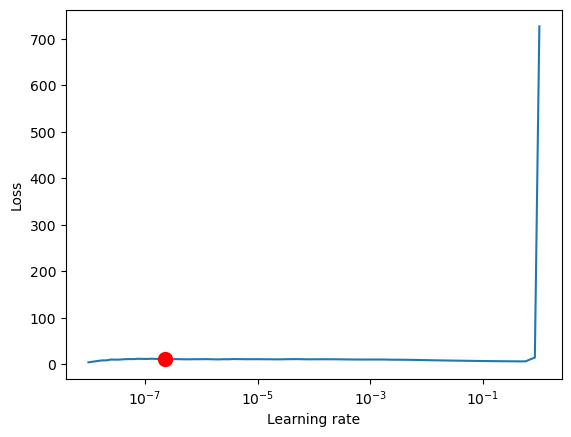

In [17]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [18]:
new_lr = lr_finder.suggestion()
model_diffusion.hparams.learning_rate = 0.01
model_diffusion.learning_rate = 0.01
#model_diffusion.hparams.learning_rate = new_lr
#model_diffusion.learning_rate = new_lr

In [22]:
trainer.fit(model_diffusion, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
--------------------------------------------------------------
0  | coboundary_vec_out         | ParameterList | 5.0 K 
1  | coboundary_vec_in          | ParameterList | 5.0 K 
2  | graph_to_sheaf             | Linear        | 34.1 K
3  | graph_to_sheaf2            | Linear        | 420   
4  | self_energy_channel_mixing | Linear        | 20    
5  | self_energy_stalk_mixing   | Linear        | 30    
6  | diffusion_stalk_mixing     | Linear        | 30    
7  | diffusion_channel_mixing   | Linear        | 20    
8  | lin_left_weights           | ModuleList    | 75    
9  | lin_right_weights          | ModuleList    | 48    
10 | batch_norms  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [23]:
torch.diag(1.+5*torch.ones(3))

tensor([[6., 0., 0.],
        [0., 6., 0.],
        [0., 0., 6.]])

wandb: Network error (ReadTimeout), entering retry loop.


In [19]:
import torch
from torch_sparse import coalesce

In [23]:
index = torch.tensor([[1, 0, 1, 0, 2, 1],
                      [0, 1, 1, 1, 0, 0]])
value = torch.Tensor([1,2,3,4,5,6])

index, value = coalesce(index, value, m=3, n=2)

In [24]:
index

tensor([[0, 1, 1, 2],
        [1, 0, 1, 0]])

In [25]:
value

tensor([6., 7., 3., 5.])